In [1]:
from time import time,ctime
import datetime
import math
import random

#make random reproducable
random.seed(1)

import pandas
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#client
#    evaluate new datapoint
#    send update to server
#    load model (predictor and std,mean)
#    
#server
#    train with new datapoints
#    calculate new std,mean
#    update client
#    
#sensor
#    push data to client

#sensor = Sensor(path=r'C:\Users\Jens\Desktop\data_ip5\raw-_sorted.csv')

## class definitions

In [3]:
class Sensor:

    def __init__(self, path, min_val, max_val):
        '''
        max_x and min_x are used for normalization
        '''
        self._diff = max_val-min_val
        self._min_val = min_val
        self._dataframe = pandas.read_csv(path, sep=',')
        print('dataframe shape:', self._dataframe.shape)
        self._datapoint_generator = (val[1] for val in self._dataframe.values)

    def plot_all_datapoints(self):
        plt.plot([val[1] for val in self._dataframe.values], label='measurements')
        plt.ylabel('value')
        plt.legend(loc='upper left')
        plt.show()

    def push_datapoint(self, client):
        client.evaluate_new_datapoint((self._datapoint_generator.__next__()-self._min_val)/self._diff)

In [4]:
class MockSensor:

    def __init__(self, signal_to_noise=1, error_rate=0.0, error_duration=1):
        self._snr = 1/signal_to_noise
        self._error_occurence = error_rate/error_duration
        self._error_duration = error_duration
        self._datapoint_generator = (math.sin(i/10) for i in range(100000))

    def push_datapoint(self, client):
        if random.random() < self._error_occurence:
            for i in range(self._error_duration):
                client.evaluate_new_datapoint((math.sin(i/5)+1)/2)
        else:
            data_point = max(0, min(1, (self._datapoint_generator.__next__()+1)/2 + self._snr*random.uniform(-1, 1)))
            client.evaluate_new_datapoint(data_point)

In [5]:
class NNModel:

    def __init__(self, nr_inout_nodes, nr_middle_nodes):
        self._n = nr_inout_nodes
        self._nr = nr_middle_nodes
        self.isTrained = False

    def setup(self):
        self._model = Sequential()
        
        self._model.add(Dense(self._n, activation='relu', input_shape=(self._n,)))
        self._model.add(Dense(self._nr, activation='relu'))
        self._model.add(Dense(self._n, activation='sigmoid'))
        self._model.compile(optimizer='rmsprop',
                           loss='mean_squared_error',
                           metrics=['accuracy'])

    def train(self, samples, epochs, batch_size):
        self._model.fit(samples, samples, epochs=epochs, batch_size=batch_size)
        self.isTrained = True

    def predict(self, x):
        return self._model.predict(x)
    
    def save(self):
        self._model.save('autoencoder.h5')

    def load(self):
        self._model = load_model('autoencoder.h5')
        self.isTrained = True

In [6]:
class Client:

    def __init__(self, nn_model, buffer_size, data_len):
        self._nn_model = nn_model
        self._buffer_size = buffer_size
        self._data_len = data_len

        self._datapoint_buffer = []
        self._error_sigma_history = []
        self._error_mean = 0
        self._error_sigma = 0


    def update_model(self, error_mean, error_sigma):
        self._nn_model.load()
        self._error_mean = error_mean
        self._error_sigma = error_sigma

    def evaluate_new_datapoint(self, datapoint):
        '''
        performance critical
        '''
        self._datapoint_buffer.append(datapoint)
        
        if (self._nn_model.isTrained):
            x_sample = self._datapoint_buffer[-self._data_len:]
            y_sample = self._autoencode(x_sample)
            error_sigma = self._calculate_error_sigma(x_sample, y_sample)
        else:
            error_sigma = 0
        self._error_sigma_history.append(error_sigma)

    def plot_datapoints(self):
        plt.plot(self._datapoint_buffer, label='datapoints')
        plt.ylabel('value')
        plt.legend(loc="upper left")
        plt.show()
        
    def plot_errors_sigmas(self):
        plt.plot(self._error_sigma_history, label='error sigma')
        plt.plot([3 for _ in range(len(self._error_sigma_history))], label='sigma=3')
        plt.ylabel('sigma')
        plt.legend(loc='upper left')
        plt.show()

    def plot_most_recent_comparison(self):
        x_sample = self._datapoint_buffer[-self._data_len:]
        y_sample = self._autoencode(x_sample)
        plt.plot(x_sample, label='measured')
        plt.plot(y_sample, label='autoencoded')
        plt.ylabel('value')
        plt.legend(loc='upper left')
        plt.show()
    
    def _calculate_error_sigma(self, x_eval, y_eval):
        len_eval = len(x_eval)
        error = sum([(x_eval[idx]-y_eval[idx])**2 for idx in range(len_eval)])
        return abs(error-self._error_mean)/self._error_sigma

    def _autoencode(self, x_eval):
        return self._nn_model.predict([x_eval])[0]

    def get_datapoint_update(self):
        if len(self._datapoint_buffer) >= 2*self._buffer_size:
            update_datapoints = self._datapoint_buffer[:self._buffer_size]
            #self._datapoint_buffer = self._datapoint_buffer[self._buffer_size:]
            #self._error_sigma_history = self._error_sigma_history[self._buffer_size:]
            return update_datapoints
        else:
            return []

In [7]:
class Server:
    
    def __init__(self, nn_model, buffer_size, data_len):
        self._nn_model = nn_model
        self._buffer_size = buffer_size
        self._data_len = data_len

        self._datapoints = []
        self._mean = 0
        self._sigma = 0

    def train_with_new_datapoints(self, datapoints):
        self._datapoints.extend(datapoints)
        if len(self._datapoints) >= self._buffer_size*2:
            train_samples = self.get_prioritized_samples(self._buffer_size, self._data_len)
        else:
            train_samples = self.get_random_samples(self._buffer_size, self._data_len)

        self._nn_model.train(train_samples, 10, 100)
        self._nn_model.save()
        self._calculate_mean_and_sigma()

    def update_client(self, client):
        client.update_model(self._mean, self._sigma)

    def _calculate_mean_and_sigma(self):
        test_samples = self.get_random_samples(self._buffer_size, self._data_len)
        prediction = self._nn_model.predict(test_samples)
        errors = [sum([(test_samples[j][i]-prediction[j][i])**2 for i in range(self._data_len)]) for j in range(len(test_samples))]

        #TODO: remove after debugging
        plt.hist(errors)
        plt.show()
        
        self._mean = np.mean(errors)
        self._sigma = np.std(errors)
        print('mean =', self._mean)
        print('sigma =', self._sigma)

    def _get_sample(self, idx, m):
        return self._datapoints[idx:idx+m]

    def get_random_samples(self, n, m):
        '''
        get random sample from whole pool
        '''
        return [self._get_sample(random.randint(0,len(self._datapoints)-m), m) for _ in range(n)]

    def get_prioritized_samples(self, n, m):        
        '''
        get most recent n/2 <results> and from random n/2 <indices>
        '''
        n_new = int(n/2)
        n_rand = n-n_new
        samples = []
        for idx in range(len(self._datapoints)-n_new-m, len(self._datapoints)-m):
            samples.append(self._get_sample(idx, m))
        for _ in range(n_rand):
            samples.append(self._get_sample(random.randint(0,len(self._datapoints)-m-n), m))
        return samples

## processing

dataframe shape: (275500, 2)
Train on 2000 samples
Epoch 1/10
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.0094 - accuracy: 0.0010
Epoch 2/10
2000/2000 [==============================] - 1s 384us/sample - loss: 0.0046 - accuracy: 5.0000e-04
Epoch 3/10
2000/2000 [==============================] - 1s 385us/sample - loss: 0.0043 - accuracy: 0.0000e+00
Epoch 4/10
2000/2000 [==============================] - 1s 425us/sample - loss: 0.0040 - accuracy: 5.0000e-04
Epoch 5/10
2000/2000 [==============================] - 1s 407us/sample - loss: 0.0039 - accuracy: 0.0000e+00
Epoch 6/10
2000/2000 [==============================] - 1s 522us/sample - loss: 0.0037 - accuracy: 0.0000e+00
Epoch 7/10
2000/2000 [==============================] - 1s 695us/sample - loss: 0.0036 - accuracy: 5.0000e-04
Epoch 8/10
2000/2000 [==============================] - 1s 595us/sample - loss: 0.0036 - accuracy: 0.0010
Epoch 9/10
2000/2000 [==============================] - 1s 504us/sample - loss:

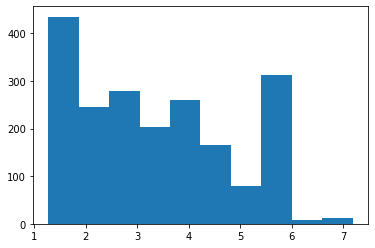

mean = 3.3144228567638967
sigma = 1.507409377496323
0 / 200


In [ ]:
data_len = 1000
hidden_len = int(data_len * 0.65)
buffer_size = 2000

client_nn_model = NNModel(data_len, hidden_len)

server_nn_model = NNModel(data_len, hidden_len)
server_nn_model.setup()

client = Client(client_nn_model, buffer_size, data_len)
server = Server(server_nn_model, buffer_size, data_len)

sensor = Sensor(path=r'C:\Users\Jens\Desktop\data_ip5\raw-_sorted-_cleaned_trimmed_resampled_100x.csv',
                min_val=0,
                max_val=14031)
#sensor = MockSensor(signal_to_noise=5, error_rate=0.1, error_duration=10)

for _ in range(2*buffer_size):
    sensor.push_datapoint(client)

server.update_client(client)

number_of_buffers_pushes = 200

for i in range(number_of_buffers_pushes*buffer_size):
    if i%buffer_size == 0:
        dpu = client.get_datapoint_update()
        server.train_with_new_datapoints(dpu)
        server.update_client(client)
        print(i//buffer_size, '/', number_of_buffers_pushes)
    sensor.push_datapoint(client)
print('finished')

In [ ]:
client.plot_datapoints()
client.plot_errors_sigmas()
client.plot_most_recent_comparison()

In [ ]:
sorted_non_zero_errors = sorted([(idx, error) for idx, error in enumerate(client._error_sigma_history) if error != 0], key=lambda x: x[1])
max_idx = sorted_non_zero_errors[-1][0]
min_idx = sorted_non_zero_errors[0][0]

print(max_idx, min_idx)

max_sample = client._datapoint_buffer[max_idx-data_len:max_idx]
min_sample = client._datapoint_buffer[min_idx-data_len:min_idx]

max_pred = client._autoencode(max_sample)
min_pred = client._autoencode(min_sample)

#print('max', sum([(max_sample[i]-max_pred[i])**2 for i in range(50)]))
#print('min', sum([(min_sample[i]-min_pred[i])**2 for i in range(50)]))

#print('mean', client._error_mean)
#print('sigma', client._error_sigma)

In [ ]:
        plt.plot(max_sample, label='measured')
        plt.plot(max_pred, label='autoencoded')
        plt.ylabel('value')
        plt.legend(loc='upper left')
        plt.show()

In [ ]:
        plt.plot(min_sample, label='measured')
        plt.plot(min_pred, label='autoencoded')
        plt.ylabel('value')
        plt.legend(loc='upper left')
        plt.show()

In [ ]:
sensor = Sensor(path=r'C:\Users\Jens\Desktop\data_ip5\raw-_sorted-_cleaned_trimmed_resampled_100x.csv',
                min_val=0,
                max_val=14031)

sensor.plot_all_datapoints()

# END

test_samples = get_random_samples(test_data, 100, n)
for i in range(10):
    test_samples.append([math.sin((i+random.randint(0,20))/30) for i in range(100)])
prediction = nn_model.predict(test_samples)

errors = [sum([(test_samples[j][i]-prediction[j][i])**2 for i in range(n)]) for j in range(len(test_samples))]

mean = np.mean(errors)
std = np.std(errors)
print('mean', mean)
print('std', std)
std1 = [e for e in errors if (e>mean+std)]
std2 = [e for e in errors if (e>mean+std*2)]
std3 = [e for e in errors if (e>mean+std*3)]
std4 = [e for e in errors if (e>mean+std*4)]
print(len(std1))
print(len(std2))
print(len(std3))
print(len(std4))

def get_sample(data, idx, m):
    return data[idx:idx+m]

def get_random_samples(data, n, m):
    '''
    get random sample from whole pool
    '''
    return [get_sample(data, random.randint(0,len(data)-m), m) for _ in range(n)]

def get_prioritized_samples(data, n, m):
    '''
    get most recent n/2 <results> and from random n/2 <indices>        
    '''
    n_new = int(n/2)
    n_rand = n-n_new
    samples = []
    for idx in range(len(data)-n_new-m, len(data)-m):
        samples.append(get_sample(data, idx, m))
    for _ in range(n_rand):
        samples.append(get_sample(data, datarandom.randint(0,len(data)-m-n), m))
    return samples

for i in range(99, 101):
    plt.plot(test_samples[i], label='real')
    plt.plot(prediction[i], label='prediction')
    plt.legend(loc="upper left")
    plt.ylabel('value')
    plt.show()

y_test = network_model.predict(np.array(x_test))

a = [list(i) for i in y_test]
b = list(x_test)



i = n_samples
plt.plot(a[i], label='predicted')
plt.plot(b[i], label='real')
plt.legend(loc="upper left")
plt.ylabel('value')
plt.show()

diff_distribution = [sum([abs(a[sample_idx][elem_idx]-b[sample_idx][elem_idx])**2 for elem_idx in range(n)]) for sample_idx in range(n_samples+1)]

plt.hist(diff_distribution)
plt.show()

std = np.std(diff_distribution)
mean = np.mean(diff_distribution)

print('std', std)
print('mean', mean)

std_x = 3

diff_idxs = [i for i, e in enumerate(diff_distribution) if (e > (mean+std*std_x)) or (e < (mean-std*std_x))]
print(diff_idxs)